# Analysis 2/14/25

- Empirical p-value & FDR calculation based on null distribution of NT gRNAs
    - One or two sided test?
- Manual generation of LFC values based on RPM with psuedocount of 1

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [13]:
#loading in barcode counts

ABE_counts = pd.read_csv('mageck/ABE_bc_counts.txt', sep='\t')
CBE_counts = pd.read_csv('mageck/CBE_bc_counts.txt', sep='\t')


#and normalize to generate RPM values
samples_CBE = list(CBE_counts.columns[2:])

CBE_RPM = CBE_counts.copy()

#add pseudocount of 1 to each sample
#and normalize + calculate RPM
pseudocount = 1
for k in samples_CBE:
    col = np.asarray(CBE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    CBE_RPM[k] = rpm


#and do the same for ABE
ABE_RPM = ABE_counts.copy()
samples_ABE = list(ABE_counts.columns[2:])

pseudocount = 1
for k in samples_ABE:
    col = np.asarray(ABE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    ABE_RPM[k] = rpm

In [11]:
CBE_RPM[CBE_RPM['gene'].isin(['non_target', 'safe_target'])]

,sgRNA,gene,spleen1,spleen2,spleen3,spleen4,spleen5,spleen6,spleen7,spleen8,...,input_rep1,input_rep2,input_rep3,d5_rep1,d5_rep2,d5_rep3,d15_rep1,d15_rep2,d15_rep3,plasmidlib
12225,gRNA_13286,safe_target,109.0,360.0,2502.0,679.0,553.0,438.0,363.0,423.0,...,860.0,1178.0,723.0,423.0,413.0,838.0,491.0,3468.0,679.0,769.0
12226,gRNA_13287,safe_target,575.0,1641.0,433.0,98.0,1312.0,240.0,111.0,162.0,...,1065.0,638.0,257.0,362.0,91.0,859.0,40.0,260.0,148.0,396.0
12227,gRNA_13288,safe_target,666.0,557.0,338.0,956.0,287.0,370.0,458.0,4946.0,...,941.0,1031.0,904.0,264.0,4055.0,1194.0,644.0,503.0,313.0,622.0
12228,gRNA_13289,safe_target,1852.0,357.0,4372.0,814.0,1632.0,696.0,2505.0,157.0,...,1402.0,1698.0,1732.0,1168.0,1286.0,1922.0,1671.0,3489.0,1729.0,849.0
12229,gRNA_13290,safe_target,904.0,586.0,682.0,527.0,2036.0,1114.0,1084.0,195.0,...,255.0,1026.0,593.0,214.0,73.0,809.0,189.0,322.0,251.0,460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12656,gRNA_13727,non_target,2551.0,484.0,2301.0,3015.0,1354.0,1306.0,5112.0,4653.0,...,3532.0,2263.0,4724.0,2240.0,2987.0,2708.0,1460.0,1711.0,994.0,1118.0
12657,gRNA_13728,non_target,2444.0,3319.0,1626.0,3885.0,2259.0,2554.0,1304.0,2591.0,...,1411.0,1774.0,12119.0,2586.0,649.0,1199.0,3568.0,4353.0,3232.0,1443.0
12658,gRNA_13729,non_target,243.0,16.0,184.0,581.0,46.0,0.0,448.0,596.0,...,400.0,2001.0,6009.0,293.0,278.0,612.0,1373.0,2645.0,370.0,687.0
12659,gRNA_13730,non_target,1988.0,771.0,325.0,375.0,533.0,528.0,127.0,155.0,...,1794.0,1343.0,1929.0,1321.0,1970.0,1127.0,2203.0,129.0,533.0,1154.0


In [25]:
import numpy as np
from scipy.stats import combine_pvalues


def one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target']):
    ''' 
    condition_of_interest = name of condition (e.g. "spleen")
    samp_of_interest = list of all replicates ["spleen1", "spleen2", "spleen3"]
    '''

    # null distribution from NT-gRNAs (e.g., log2 fold changes)


    #furthermore, add in the intron-targetting gRNAs to the distribution
    non_targ = LFC_df[LFC_df['gene'].isin(null)].reset_index(drop=True)
    #non_targ = LFC_df[LFC_df['gene'].isin(['NT'])].reset_index(drop=True)

    data = non_targ[samp_of_interest].to_numpy().flatten()
    nt_gRNA_values = data
    print(len(nt_gRNA_values))

    #targeting gRNAs with 3 replicates per guide
    #including NT gRNAs here for completeness even though they're in the null distribution
    gRNA_values = np.asarray(LFC_df[samp_of_interest])


    # Function to compute empirical p-values
    def empirical_p_value(observed, null_distribution):

        #S+1/N+1 for p-value calculation
        #Where is S=# of values more extreme than null (N)
        #S+1/N+1 for p-value calculation
        #Where is S=# of values more extreme than null (N)
        S = sum(null_distribution >= observed)
        N = len(null_distribution)
        p = (S+1)/(N+1)

        #return np.mean(null_distribution >= observed)
        return p

    # Compute p-values for each replicate separately
    p_values_per_replicate = np.array([
        [empirical_p_value(rep, nt_gRNA_values) for rep in gRNA] 
        for gRNA in gRNA_values
    ])

    # Combine p-values across replicates using Fisher's method
    combined_p_values = np.array([
        combine_pvalues(p_vals, method='fisher')[1]  # Extract p-value from Fisher's test
        for p_vals in p_values_per_replicate
    ])

    # Adjust for multiple testing (Benjamini-Hochberg FDR)
    from statsmodels.stats.multitest import multipletests
    adjusted_p_values = multipletests(combined_p_values, method='fdr_bh')[1]

    # Output results
    LFC_df[f'p_high_unadjusted_{condition_of_interest}'] = combined_p_values
    LFC_df[f'FDR_high_{condition_of_interest}'] = adjusted_p_values

    return LFC_df #, p_values_per_replicate

In [87]:
import numpy as np
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import multipletests

def two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target']):
    ''' 
    condition_of_interest = name of condition (e.g. "spleen")
    samp_of_interest = list of all replicates ["spleen1", "spleen2", "spleen3"]
    '''

    # Construct the null distribution
    non_targ = LFC_df[LFC_df['gene'].isin(null)].reset_index(drop=True)
    nt_gRNA_values = non_targ[samp_of_interest].to_numpy().flatten()

    # Targeting gRNAs (including NT for completeness)
    gRNA_values = np.asarray(LFC_df[samp_of_interest])

    # Function to compute empirical two-tailed p-values
    def empirical_p_value(observed, null_distribution):
        S_high = sum(null_distribution >= observed)
        S_low = sum(null_distribution <= observed)
        N = len(null_distribution)

        # Compute two-sided p-value
        p_high = (S_high + 1) / (N + 1)
        p_low = (S_low + 1) / (N + 1)
        return p_high, p_low

    # Compute p-values for each replicate separately (two-tailed)
    p_values_high = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[0] for rep in gRNA] 
        for gRNA in gRNA_values
    ])
    p_values_low = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[1] for rep in gRNA] 
        for gRNA in gRNA_values
    ])

    # Combine p-values across replicates using Fisher's method
    combined_p_values_high = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_high
    ])
    combined_p_values_low = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_low
    ])

    # Adjust for multiple testing (Benjamini-Hochberg FDR)
    adjusted_p_values_high = multipletests(combined_p_values_high, method='fdr_bh')[1]
    adjusted_p_values_low = multipletests(combined_p_values_low, method='fdr_bh')[1]

    # Store results in the dataframe
    LFC_df[f'p_high_unadjusted_{condition_of_interest}'] = combined_p_values_high
    LFC_df[f'p_low_unadjusted_{condition_of_interest}'] = combined_p_values_low
    LFC_df[f'FDR_high_{condition_of_interest}'] = adjusted_p_values_high
    LFC_df[f'FDR_low_{condition_of_interest}'] = adjusted_p_values_low

    return LFC_df


In [127]:
CBE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

ABE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

edit_info =pd.read_csv('master_table_unfiltered.csv')[['gRNA_id', 'gene_name_m', 'sensor_reads', 'corr_perc', 'target_base_edit_perc', 'byproduct_INDEL_perc', 'byproduct_sub_perc', 'Editor', 'classification', 'HGVSp_h', 'HGVSp_m']]
ABE_edit_info = edit_info[edit_info['Editor']=='ABE']
CBE_edit_info = edit_info[edit_info['Editor']=='CBE']

In [89]:
#can try with using d5 as t0 as well
t0_comparison = ['input_rep1', 'input_rep2', 'input_rep3']

dmso_median = np.median(ABE_RPM[t0_comparison], axis=1)
dmso_avg = np.average(ABE_RPM[t0_comparison], axis=1)


df_holder = []
for condition_of_interest in list(ABE_samp_dict.keys()):

#condition_of_interest = 'KI-CDK9d-32_1000nM'
    samp_of_interest = ABE_samp_dict[condition_of_interest]

    #calculate log2fc
    lfc_list = []
    for k in samp_of_interest:
        col = ABE_RPM[k]
        lfc = np.log2(col/dmso_median)

        lfc_list.append(lfc)

    lfc_table = pd.DataFrame(dict(zip(samp_of_interest, lfc_list)))
    lfc_table[f'LFC_avg_{condition_of_interest}'] = np.average(lfc_table[samp_of_interest], axis=1)
    lfc_table[f'LFC_median_{condition_of_interest}'] = np.median(lfc_table[samp_of_interest], axis=1)
    lfc_table['Input_median'] = dmso_median
    ids = ABE_RPM[['sgRNA', 'gene']]

    LFC_df = pd.concat((ids, lfc_table), axis=1)
    #LFC_df = one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    df_holder.append(LFC_df)

In [128]:
combined_LFC_ABE = pd.concat(df_holder, axis=1)
combined_LFC_ABE = combined_LFC_ABE.loc[:,~combined_LFC_ABE.columns.duplicated()].copy()
combined_LFC_ABE = combined_LFC_ABE.rename(columns = {'sgRNA':'gRNA_id', 'gene':'Gene'})
combined_LFC_ABE_edit = pd.merge(combined_LFC_ABE, ABE_edit_info, on='gRNA_id')

combined_LFC_ABE_edit.sort_values(by='FDR_low_spleen')[list(combined_LFC_ABE.columns[:13]) + ['target_base_edit_perc']][:10]

,gRNA_id,Gene,spleen1,spleen2,spleen3,spleen4,LFC_avg_spleen,LFC_median_spleen,Input_median,p_high_unadjusted_spleen,p_low_unadjusted_spleen,FDR_high_spleen,FDR_low_spleen,target_base_edit_perc
1027,gRNA_13007,Vhl,-5.522186,-7.954741,-6.852688,-1.850604,-5.545055,-6.187437,235.136502,0.999999,0.000027,1.0,0.014197,99.504950
226,gRNA_2494,Ctnnb1,-2.238856,-3.021354,-3.591726,-3.351482,-3.050854,-3.186418,784.914902,1.000000,0.000020,1.0,0.014197,36.756757
407,gRNA_4141,Fbxw7,-2.148976,-2.545553,-3.408396,-3.144226,-2.811788,-2.844889,1123.279978,0.999999,0.000065,1.0,0.022515,92.645215
25,gRNA_671,Arid1a,-3.481979,-1.666607,-2.543993,-4.467769,-3.040087,-3.012986,628.853436,0.999997,0.000084,1.0,0.022515,90.340136
221,gRNA_2458,Ctnnb1,-2.974894,-1.523964,-3.519522,-2.639341,-2.664430,-2.807117,583.279661,0.999987,0.000168,1.0,0.029951,51.130435
216,gRNA_2440,Ctcf,-2.267264,-1.761775,-3.189127,-4.146675,-2.841210,-2.728195,1391.679996,0.999992,0.000149,1.0,0.029951,73.255055
875,gRNA_11449,Smarca4,-1.295408,-2.047242,-3.355822,-3.909229,-2.651925,-2.701532,853.968999,0.999905,0.000325,1.0,0.049706,57.357860
512,gRNA_5776,Jak2,-2.262699,-2.639760,-3.311431,-1.606431,-2.455080,-2.451230,626.119291,0.999981,0.000416,1.0,0.055608,39.332461
188,gRNA_2215,Crebbp,-2.288168,-3.280151,-1.033708,-1.650450,-2.063119,-1.969309,524.811137,0.999627,0.001970,1.0,0.203900,83.058104
190,gRNA_2240,Crebbp,-2.129589,-2.253097,-0.902096,-4.842945,-2.531932,-2.191343,1007.532571,0.999489,0.001930,1.0,0.203900,95.858241


In [102]:
#can try with using d5 as t0 as well
t0_comparison = ['input_rep1', 'input_rep2', 'input_rep3']

dmso_median = np.median(CBE_RPM[t0_comparison], axis=1)
dmso_avg = np.average(CBE_RPM[t0_comparison], axis=1)


df_holder2 = []
for condition_of_interest in list(CBE_samp_dict.keys()):

#condition_of_interest = 'KI-CDK9d-32_1000nM'
    samp_of_interest = CBE_samp_dict[condition_of_interest]

    #calculate log2fc
    lfc_list = []
    for k in samp_of_interest:
        col = CBE_RPM[k]
        lfc = np.log2(col/dmso_median)

        lfc_list.append(lfc)

    lfc_table = pd.DataFrame(dict(zip(samp_of_interest, lfc_list)))
    lfc_table[f'LFC_avg_{condition_of_interest}'] = np.average(lfc_table[samp_of_interest], axis=1)
    lfc_table[f'LFC_median_{condition_of_interest}'] = np.median(lfc_table[samp_of_interest], axis=1)
    lfc_table['Input_median'] = dmso_median
    ids = CBE_RPM[['sgRNA', 'gene']]

    LFC_df = pd.concat((ids, lfc_table), axis=1)
    #LFC_df = one_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null=['non_target', 'safe_target'])
    df_holder2.append(LFC_df)

In [129]:
combined_LFC = pd.concat(df_holder2, axis=1)
combined_LFC = combined_LFC.loc[:,~combined_LFC.columns.duplicated()].copy()
combined_LFC = combined_LFC.rename(columns = {'sgRNA':'gRNA_id', 'gene':'Gene'})
combined_LFC_CBE_edit = pd.merge(combined_LFC, CBE_edit_info, on='gRNA_id')



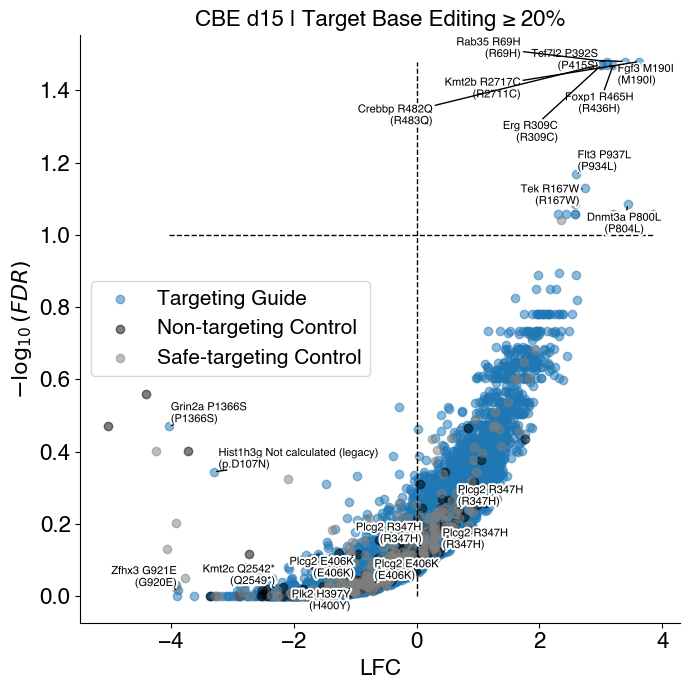

In [224]:
condition_of_interest = 'd15'
edit_cutoff = 20

samp_of_interest = CBE_samp_dict[condition_of_interest]
other_cols = ['Input_median', f'LFC_avg_{condition_of_interest}',f'LFC_median_{condition_of_interest}', 
              f'p_high_unadjusted_{condition_of_interest}',f'p_low_unadjusted_{condition_of_interest}',
              f'FDR_high_{condition_of_interest}',f'FDR_low_{condition_of_interest}',
              'gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'target_base_edit_perc', 'sensor_reads', 'classification']

subset_CBE = combined_LFC_CBE_edit[samp_of_interest + other_cols]

min_FDR = []
for i, val in subset_CBE.iterrows():
    FDR_low = -np.log10(val[f'FDR_low_{condition_of_interest}'])
    FDR_high = -np.log10(val[f'FDR_high_{condition_of_interest}'])
    min_FDR.append(max(FDR_low, FDR_high))

subset_CBE['-log10(FDR)'] = min_FDR

subset_targ = subset_CBE[subset_CBE['classification']=='targeting guide']
subset_NT = subset_CBE[subset_CBE['classification']=='non-targeting control']
subset_ST = subset_CBE[subset_CBE['classification']=='safe-targeting control']

#and then filter based on editing info
subset_targ = subset_targ[subset_targ['target_base_edit_perc']>=edit_cutoff]

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(data=subset_targ, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:blue', alpha=.5, label='Targeting Guide')
ax.scatter(data=subset_NT, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='black', alpha=.5, label='Non-targeting Control')
ax.scatter(data=subset_ST, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:grey', alpha=.5, label='Safe-targeting Control')

ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_ylabel("$-\log_{10}({FDR})$", fontsize=16)
ax.set_xlabel('LFC', fontsize=16)
ax.set_title(f'CBE {condition_of_interest} | Target Base Editing ≥ {edit_cutoff}%', fontsize=16)

bounds = [min(subset_targ[f'LFC_median_{condition_of_interest}']), max(subset_targ[f'LFC_median_{condition_of_interest}'])]
ax.plot(bounds,[1,1], linestyle='dashed', color='black', linewidth=1)
ax.plot([0,0],[0,max(subset_targ['-log10(FDR)'])], linestyle='dashed', color='black', linewidth=1)

#and then add labels to top and bottom enrichers
num_to_plot = 10
top_enrichers = subset_targ.sort_values(by=f'FDR_high_{condition_of_interest}')[:num_to_plot]
top_depleters = subset_targ.sort_values(by=f'FDR_low_{condition_of_interest}')[:num_to_plot]

tops = pd.concat((top_enrichers, top_depleters)).fillna(' ')

#first top enrichers
x = list(tops[f'LFC_median_{condition_of_interest}'])
y = list(tops['-log10(FDR)'])
t = [f"{val['Gene']} {val['HGVSp_m']}\n({val['HGVSp_h'].replace('delins','')})" for i, val in tops.iterrows()]

texts = [ax.text(x[i], y[i], t[i], fontsize=8, color='black', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                            foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

adjust_text(texts,only_move={'points':'xy', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()
#fig.savefig(f'figures/{condition_of_interest}_CBE_volcano.png', dpi=300)

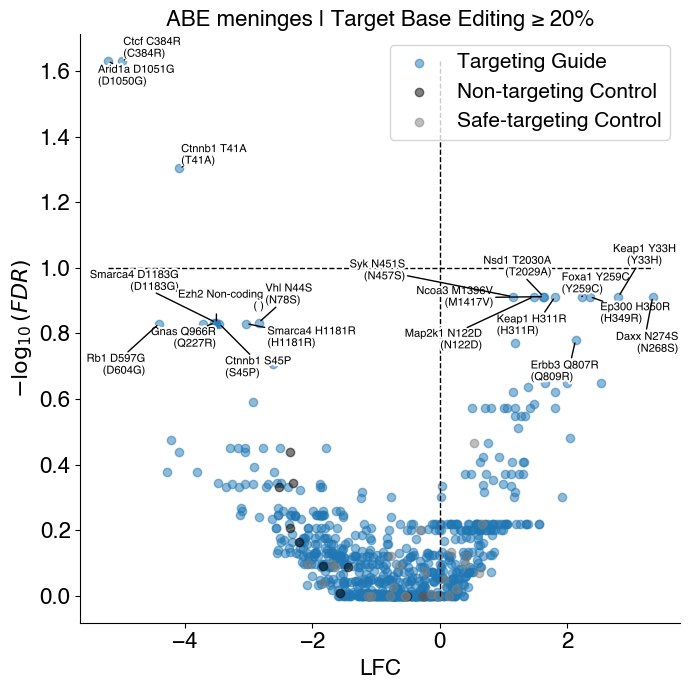

In [ ]:
condition_of_interest = 'meninges'
edit_cutoff = 20


samp_of_interest = ABE_samp_dict[condition_of_interest]
other_cols = ['Input_median', f'LFC_avg_{condition_of_interest}',f'LFC_median_{condition_of_interest}', 
              f'p_high_unadjusted_{condition_of_interest}',f'p_low_unadjusted_{condition_of_interest}',
              f'FDR_high_{condition_of_interest}',f'FDR_low_{condition_of_interest}',
              'gRNA_id', 'Gene', 'HGVSp_m', 'HGVSp_h', 'target_base_edit_perc', 'sensor_reads', 'classification']

subset_ABE = combined_LFC_ABE_edit[samp_of_interest + other_cols]

min_FDR = []
for i, val in subset_ABE.iterrows():
    FDR_low = -np.log10(val[f'FDR_low_{condition_of_interest}'])
    FDR_high = -np.log10(val[f'FDR_high_{condition_of_interest}'])
    min_FDR.append(max(FDR_low, FDR_high))

subset_ABE['-log10(FDR)'] = min_FDR

subset_targ = subset_ABE[subset_ABE['classification']=='targeting guide']
subset_NT = subset_ABE[subset_ABE['classification']=='non-targeting control']
subset_ST = subset_ABE[subset_ABE['classification']=='safe-targeting control']

#and then filter based on editing info
subset_targ = subset_targ[subset_targ['target_base_edit_perc']>=edit_cutoff]

fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(data=subset_targ, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:blue', alpha=.5, label='Targeting Guide')
ax.scatter(data=subset_NT, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='black', alpha=.5, label='Non-targeting Control')
ax.scatter(data=subset_ST, x=f'LFC_median_{condition_of_interest}', y='-log10(FDR)', c='tab:grey', alpha=.5, label='Safe-targeting Control')

ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16);
ax.set_ylabel("$-\log_{10}({FDR})$", fontsize=16)
ax.set_xlabel('LFC', fontsize=16)
ax.set_title(f'ABE {condition_of_interest} | Target Base Editing ≥ {edit_cutoff}%', fontsize=16)

bounds = [min(subset_targ[f'LFC_median_{condition_of_interest}']), max(subset_targ[f'LFC_median_{condition_of_interest}'])]
ax.plot(bounds,[1,1], linestyle='dashed', color='black', linewidth=1)
ax.plot([0,0],[0,max(subset_targ['-log10(FDR)'])], linestyle='dashed', color='black', linewidth=1)

#and then add labels to top and bottom enrichers
num_to_plot = 10
top_enrichers = subset_targ.sort_values(by=f'FDR_high_{condition_of_interest}')[:num_to_plot]
top_depleters = subset_targ.sort_values(by=f'FDR_low_{condition_of_interest}')[:num_to_plot]

tops = pd.concat((top_enrichers, top_depleters)).fillna(' ')

#first top enrichers
x = list(tops[f'LFC_median_{condition_of_interest}'])
y = list(tops['-log10(FDR)'])
t = [f"{val['Gene']} {val['HGVSp_m']}\n({val['HGVSp_h'].replace('delins','')})" for i, val in tops.iterrows()]

texts = [ax.text(x[i], y[i], t[i], fontsize=8, color='black', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                            foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

adjust_text(texts,only_move={'points':'xy', 'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))


fig.tight_layout()
#fig.savefig(f'figures/{condition_of_interest}_ABE_volcano.png', dpi=300)

# Possible updates

Possibly add in cutoff based on #input sequencing reads (on raw reads)